In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
#!pip install scikitplot

In [3]:
import math
import numpy as np
import pandas as pd

#import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


In [4]:
df = pd.read_csv("C:/Users/Nikitha/Documents/thesis/NITPML01/NITPML01/DATASET/fer2013.csv")

print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [6]:
emotion_label_to_text = {0:'hot', 1:'Bitter', 2:'Bland', 3:'Sweet', 4: 'Salty', 5: 'Spicy', 6: 'Savoury'}

In [7]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [8]:
#to know the dimensions of the image
math.sqrt(len(df.pixels[0].split(' ')))

48.0

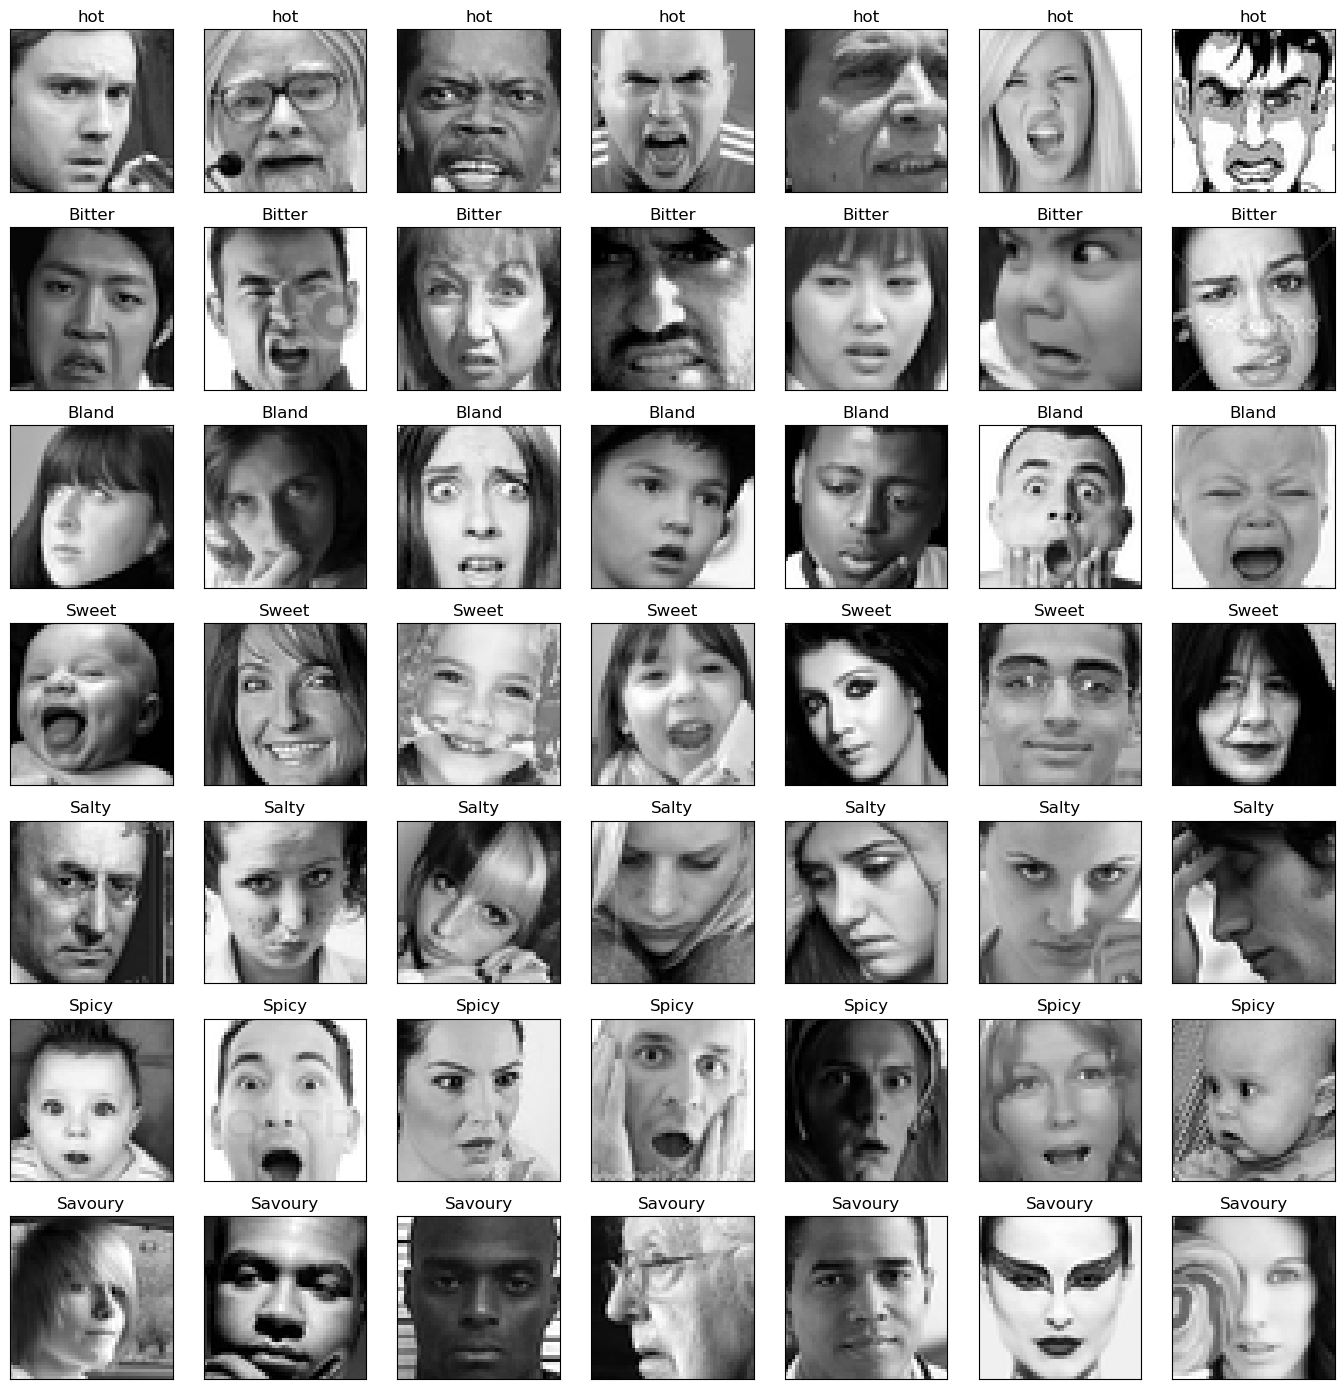

In [9]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [10]:
INTERESTED_LABELS = [1,2,3,4,5,6]

In [11]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(30934, 3)

In [13]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array

array([[[[231.],
         [212.],
         [156.],
         ...,
         [ 44.],
         [ 27.],
         [ 16.]],

        [[229.],
         [175.],
         [148.],
         ...,
         [ 27.],
         [ 35.],
         [ 27.]],

        [[214.],
         [156.],
         [157.],
         ...,
         [ 28.],
         [ 22.],
         [ 28.]],

        ...,

        [[241.],
         [245.],
         [250.],
         ...,
         [ 57.],
         [101.],
         [146.]],

        [[246.],
         [250.],
         [252.],
         ...,
         [ 78.],
         [105.],
         [162.]],

        [[250.],
         [251.],
         [250.],
         ...,
         [ 88.],
         [110.],
         [152.]]],


       [[[ 24.],
         [ 32.],
         [ 36.],
         ...,
         [173.],
         [172.],
         [173.]],

        [[ 25.],
         [ 34.],
         [ 29.],
         ...,
         [173.],
         [172.],
         [173.]],

        [[ 26.],
         [ 29.],
      

In [14]:
img_array.shape

(30934, 48, 48, 1)

In [15]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(30934, 6)

In [16]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((24747, 48, 48, 1), (6187, 48, 48, 1), (24747, 6), (6187, 6))

In [18]:
del df
del img_array
del img_labels

In [19]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [20]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [21]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net


In [22]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [23]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [24]:
batch_size = 20 #batch size of 32 performs the best.
epochs = 8
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=False
)
Model: "DCNN"

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

C:\Users\Nikitha\AppData\Local\Temp\ipykernel_11032\752625110.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/8
1237/1237 [==============================] - 688s 552ms/step - loss: 1.8639 - accuracy: 0.2754 - val_loss: 1.4702 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 2/8
1237/1237 [==============================] - 580s 468ms/step - loss: 1.4656 - accuracy: 0.4009 - val_loss: 1.3174 - val_accuracy: 0.4839 - lr: 0.0010
Epoch 3/8
1237/1237 [==============================] - 546s 441ms/step - loss: 1.2927 - accuracy: 0.4845 - val_loss: 1.1263 - val_accuracy: 0.5528 - lr: 0.0010
Epoch 4/8
1237/1237 [==============================] - 616s 498ms/step - loss: 1.2134 - accuracy: 0.5214 - val_loss: 1.0549 - val_accuracy: 0.5854 - lr: 0.0010
Epoch 5/8
1237/1237 [==============================] - 595s 481ms/step - loss: 1.1632 - accuracy: 0.5450 - val_loss: 1.0242 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 6/8
1237/1237 [==============================] - 636s 514ms/step - loss: 1.1243 - accuracy: 0.5619 - val_loss: 0.9622 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 7/8
1237/1237 [===================

In [25]:
model_json = model.to_json()
with open("model.json", "w") as yaml_file:
    yaml_file.write(model_json)
    
model.save("model.h5")

C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

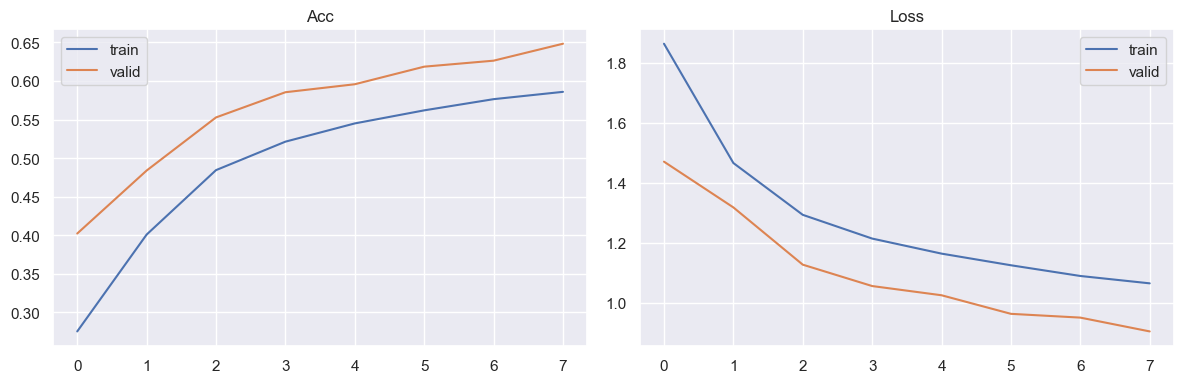

In [26]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Acc')
pyplot.tight_layout()


ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Nikitha\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

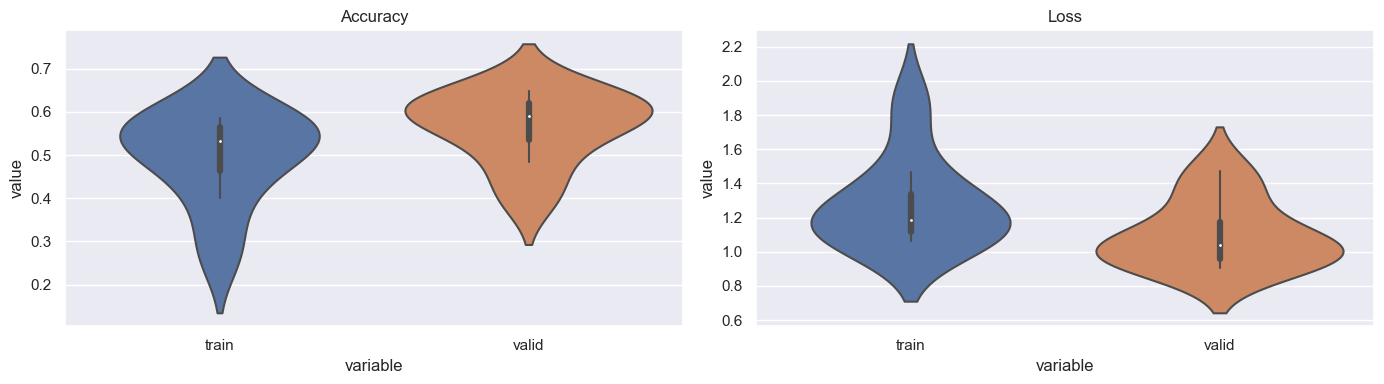

In [27]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()


ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

In [28]:
# Get training accuracy values
training_accuracy = history.history['accuracy']

# Get validation accuracy values
validation_accuracy = history.history['val_accuracy']

# Print the last accuracy value of training and validation data (at the last epoch)
print("Training Accuracy:", training_accuracy[-1])
print("Validation Accuracy:", validation_accuracy[-1])

Training Accuracy: 0.5859296321868896
Validation Accuracy: 0.6482948064804077


In [29]:
from sklearn.metrics import confusion_matrix

y_train_pred = model.predict(X_train)
y_train_true = np.argmax(y_train, axis=1)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Get predictions for validation set
y_valid_pred = model.predict(X_valid)
y_valid_true = np.argmax(y_valid, axis=1)
y_valid_pred_classes = np.argmax(y_valid_pred, axis=1)

# Confusion matrix for training set
confusion_train = confusion_matrix(y_train_true, y_train_pred_classes)
print("Confusion Matrix (Training Set):\n", confusion_train)

# Confusion matrix for validation set
confusion_valid = confusion_matrix(y_valid_true, y_valid_pred_classes)
print("Confusion Matrix (Validation Set):\n", confusion_valid)





194/194 [==============================] - 34s 173ms/step
Confusion Matrix (Training Set):
 [[   0   93   36  267   17   25]
 [   0 1389  211 1476  541  480]
 [   3  476 4991  908  166  647]
 [   1  646  157 3216   68  773]
 [   1  559  121  125 2197  199]
 [   1  554  165 1599   96 2543]]
Confusion Matrix (Validation Set):
 [[   0   28   16   54    3    8]
 [   0  344   44  401  127  108]
 [   0  140 1228  219   33  178]
 [   0  168   30  788   14  216]
 [   0  140   30   24  562   44]
 [   0  121   47  372   32  668]]
